In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
from tqdm import tqdm
import yfinance as yf
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera

plt.rcParams["figure.figsize"] = (16,8)


In [5]:
def get_timeseries(fund_dict, inp_res):
    """
    Returns a dataframe of timeseries prices resampled to a particular resolution.
    
    Args:
        fund_dict: 
            dict of funds consisting keys with the yf ticker code as the keys and the desired column name as values
        inp_res: string
            String of the desired resolution for the data to be resampled to.

    Returns:
        dataframe of the adjusted close price for the funds in the dictionary.
    """ 
    
    out_df = yf.download([*fund_dict.keys()])['Adj Close'].resample(inp_res).last().rename(columns=fund_dict)
    out_df.index = pd.to_datetime(out_df.index, errors='coerce')
    out_df = out_df.sort_index()
    return out_df

funds = {
    '0P0000TKZO.L' : 'LifeStrategy_100', 
    '0P00018XAR.L' : 'FTSE_Global_All_Cap'
}

resolutions = {
    'Daily' : ['D', 252],
    'Weekly' : ['W', 52],
    'Monthly' : ['BM', 12],
}


### Input resolution
selected_resolution = 'Daily'

vg_funds = get_timeseries(funds, resolutions[selected_resolution][0])


[*********************100%***********************]  2 of 2 completed


Firstly we rebase the series so that they start from the same point. To do this we divide it by it's first price in the series, we can think of this as the percentage gain that each of the funds achieved over the history. We'll plot them below.


Looks like there's an outlier there in Q3 of 2021, as I can't find any evidence of the Vanguard apocalypse on the 6th September 2021, 
I think it's fair to assume this is bad data. Will fix this up and forward fill that value.



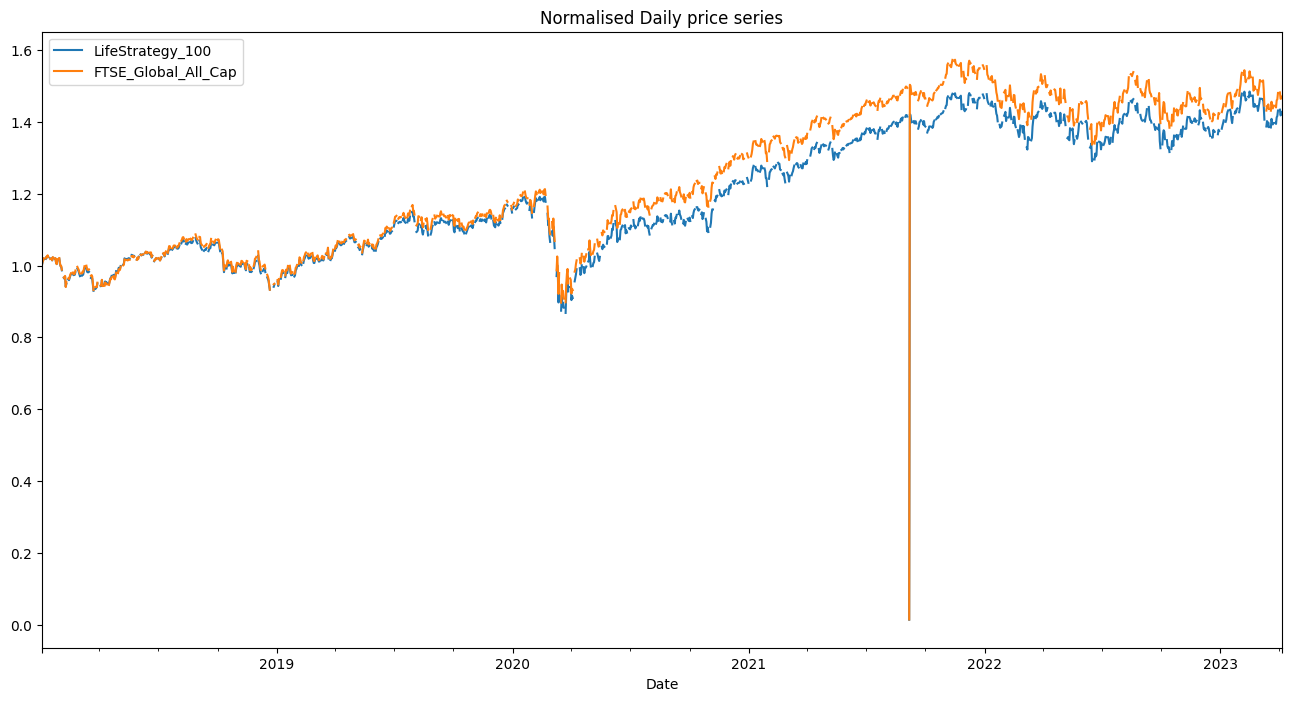

Outlier date and price:
LifeStrategy_100      2021-09-06 00:00:00+01:00
FTSE_Global_All_Cap   2021-09-06 00:00:00+01:00
dtype: datetime64[ns, Europe/London] 

LifeStrategy_100       294.432587
FTSE_Global_All_Cap    176.815796
dtype: float64 



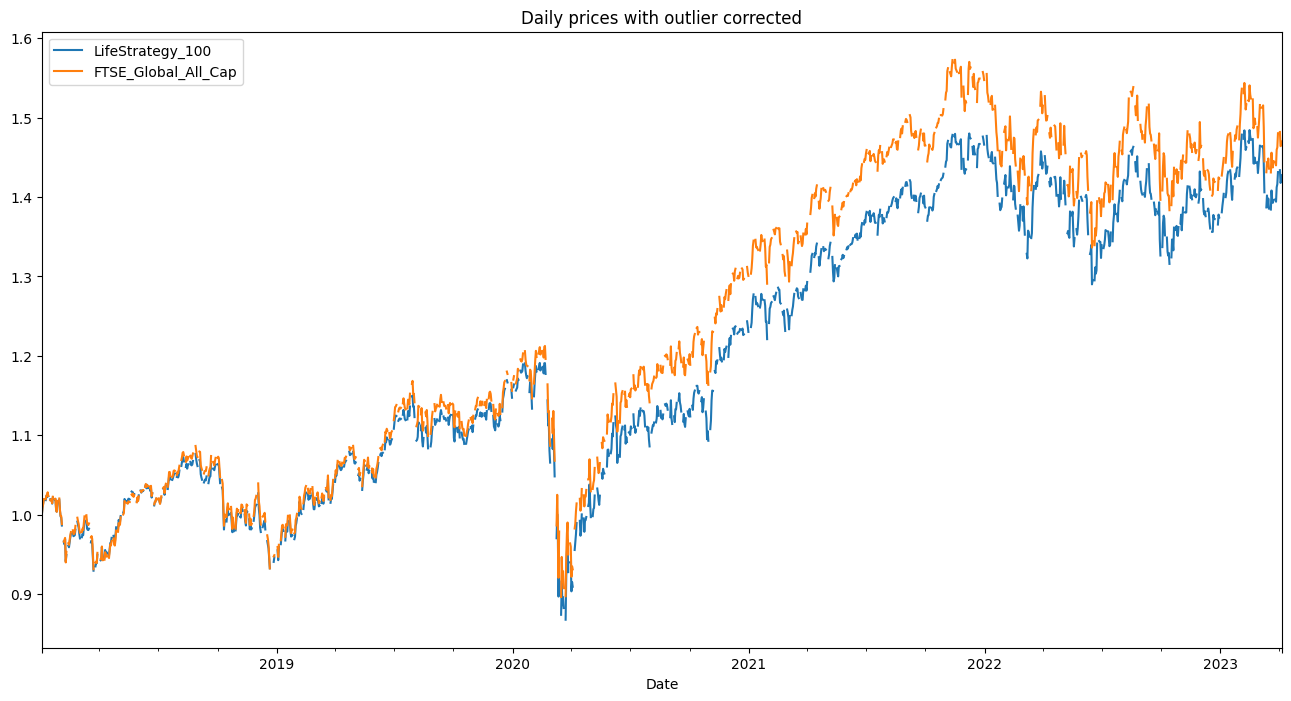

In [6]:
vg_funds_norm = vg_funds.div(vg_funds.iloc[0])
vg_funds_norm.plot()
plt.title(f'Normalised {selected_resolution} price series')

if selected_resolution == 'Daily':
    print("\nLooks like there's an outlier there in Q3 of 2021, as I can't find any evidence of the Vanguard apocalypse on the 6th September 2021, \nI think it's fair to assume this is bad data. We'll fix this up and forward fill that value.\n")
    plt.show()
    print('Outlier date and price:')
    print(f'{vg_funds.idxmin()} \n')
    print(f'{vg_funds.min()} \n')
    
    for fund in funds.keys():
        vg_funds[funds[fund]] = vg_funds[funds[fund]].replace(vg_funds[funds[fund]].min(), method='ffill')

    vg_funds_norm = vg_funds.div(vg_funds.iloc[0])
    vg_funds_norm.plot()
    plt.title(f'{selected_resolution} prices with outlier corrected')
    plt.show()

Initial thoughts:

Both series look extremely correlated to each other, with both returning over 40% over the history.

VG FTSE Global All Cap looks to have higher returns than the VG LifeStrategy 100 but at the cost of higher volatility. Comparison of risk adjusted measures (such as Sharpe ratio) will quantify whether this extra volatility pays a higher premia. 

We'll look at some descriptive statistics to see if anything jumps out.

In [7]:
def desc_stats(inp_df):
    """
    Returns a dataframe of extended decsriptive statistics.
    
    Args:
        inp_df: 
            the dataframe to be summarised.

    Returns:
        dataframe with the normal statistics from pandas describe function some extensions.
    """     
    out_df = inp_df.describe()
    out_df.loc['Var'] = inp_df.var()
    out_df.loc['Skewness'] = inp_df.skew()
    out_df.loc['Kurtosis'] = inp_df.kurt()
    out_df.loc['IQR'] = inp_df.quantile(0.75) - inp_df.quantile(0.25)
    out_df.loc['Range'] = inp_df.max() - inp_df.min()

    return out_df

vg_funds_LR = np.log(vg_funds).diff().dropna()

metric_comparison = desc_stats(vg_funds_LR)
metric_comparison


,LifeStrategy_100,FTSE_Global_All_Cap
count,1051.000000,1051.000000
mean,0.000322,0.000366
std,0.009618,0.010189
min,-0.080224,-0.073575
25%,-0.004279,-0.004377
50%,0.000810,0.001003
75%,0.005259,0.005613
max,0.061417,0.061272
Var,0.000093,0.000104
Skewness,-0.538896,-0.351277


In [8]:
def sharpe_ratio(series, rfr, annualize, periods):
    """
    Returns the sharpe ratio of a log returns series.
    
    Args:
        series: pd.series 
            pandas series of returns to be analysed.
        rfr: float
            the risk free rate to measure the excess returns of the series.
        annualize: bool
            boolean flag to select the annualize option.
        periods: int
            number of periods in the year to annualize the value.

    Returns:
        float
            sharpe ratio of the series.
    """ 
    
    if annualize:
        return (periods**(1/2)) * ((np.mean(series) - rfr) / np.std(series))
    else:
        return ((np.mean(series) - rfr) / np.std(series))

for col in vg_funds_LR.columns:    
    metric_comparison.loc['Sharpe_Ratio', col] = round(sharpe_ratio(vg_funds_LR[col], 0, 1, resolutions[selected_resolution][1]),3)
    
metric_comparison.loc[['Sharpe_Ratio']]


,LifeStrategy_100,FTSE_Global_All_Cap
Sharpe_Ratio,0.531,0.57


This suggests that the VG FTSE Global All Cap is the better risk adjusted investment, but sharpe ratio itself has some assumptions of normality baked into the calculation. We'll have a look at the histogram of returns to see if this assumption is a safe one.

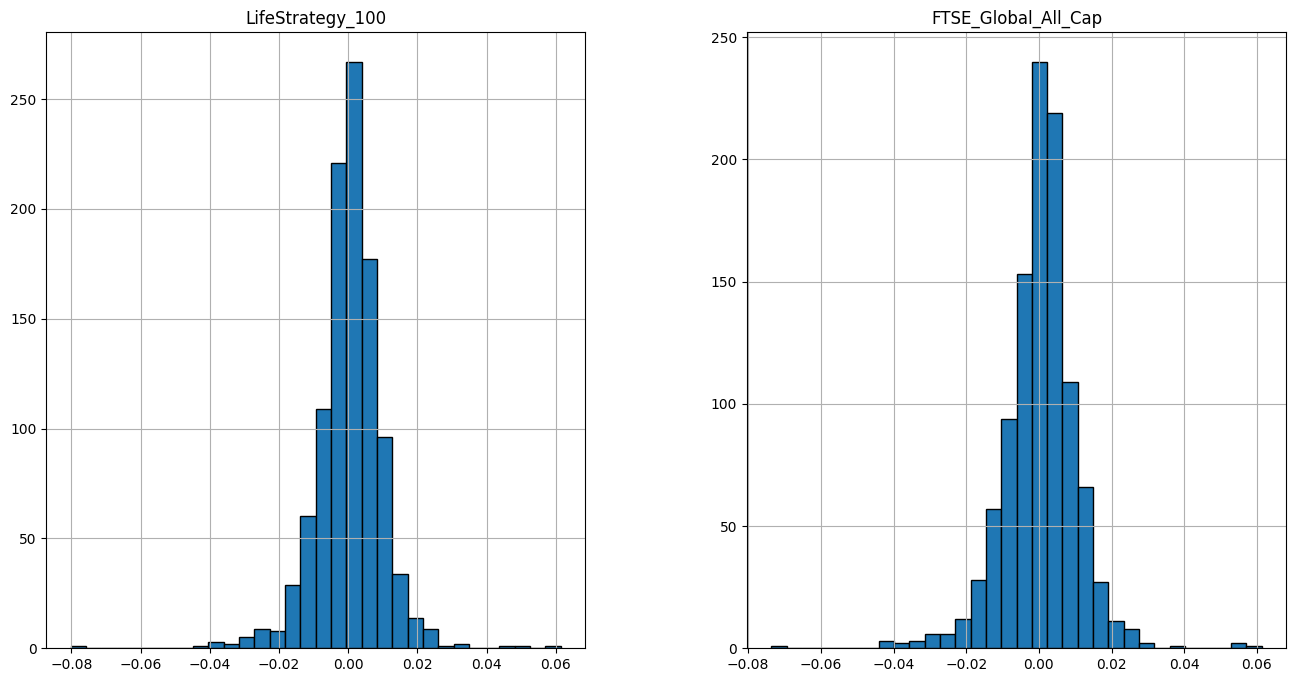

In [9]:
def binner(inp_df):
    """
    Returns the optimal number of bins for the data.
    
    Taking the sqrt of the length of the array 
    then casting as an int to avoid errors.
    
    Args:
        dataframe: 
            pandas dataframe, can also take series/list/array.

    Returns:
        int
            bin value.
    """     
    return int(np.sqrt(len(inp_df)))

vg_funds_LR.hist(bins=binner(vg_funds_LR), edgecolor='k')
plt.show()

As we can see here (and in most histograms of financial returns), the peak is pronounced and the tails are fatter than expected from a normal distribution. We'll use the Kolmogorov-Smirnov test and Jarque-Bera test for normality and look for p values > 0.05. We'll also plot the empirical CDF against the theoretical normal CDF to see if the visual differences in the histograms hold up.

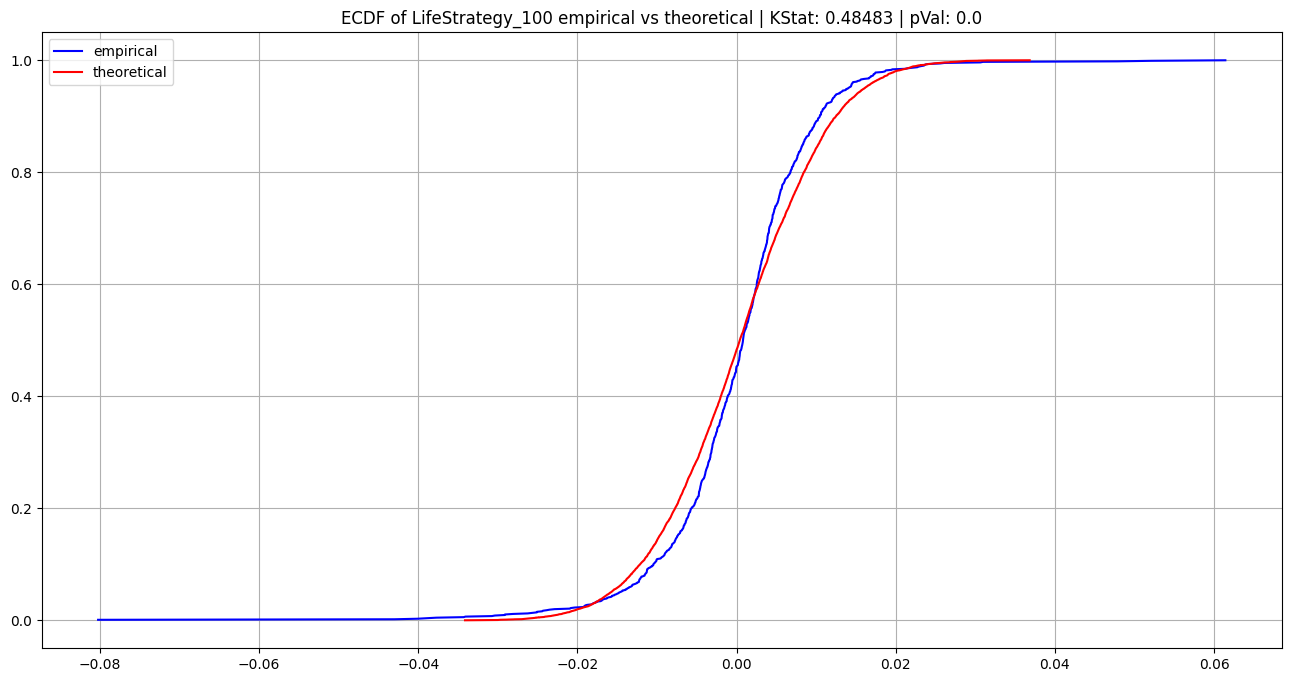

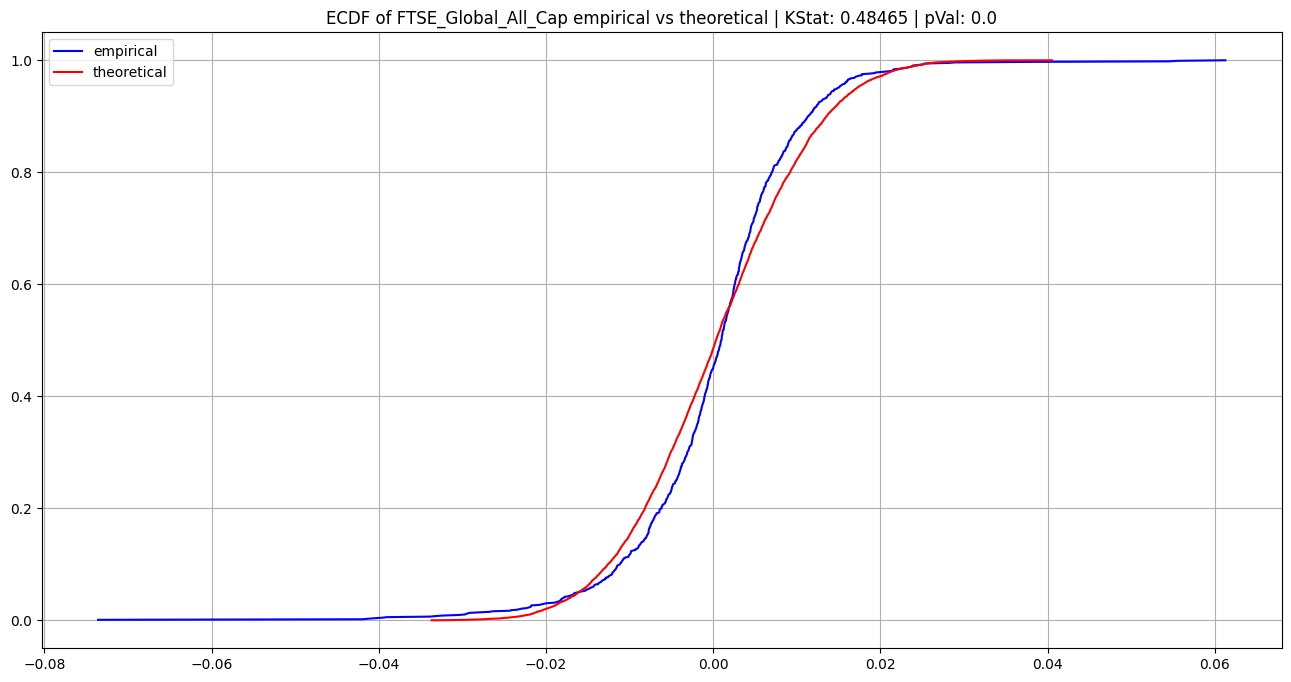

,LifeStrategy_100,FTSE_Global_All_Cap
KS Test,5.280308e-228,7.992330e-228
JB Test,0.000000e+00,0.000000e+00


In [10]:
def ecdf(data):
    """
    Returns x and y values for the ECDF of the input.
    
    Args:
        data: arr
            array of data.

    Returns:
        x: arr
            x values.
        y: arr
            y values.            
    """         
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, (n+1)) / n
    return x, y

def kstat(inp_df, col):
    """
    Returns p Value of the Kolmogorov-Smirnov test.
    Plots the theoretical normal distribution and
    ECDF of the input data.
    
    Args:
        inp_df: dataframe
            entire dataframe.
        col: string
            column for values.

    Returns:
        pVal: float
            p value of the KS test.            
    """      
    kstat, pVal = stats.ks_1samp(inp_df[col].dropna(), stats.norm.cdf) # (np.random.exponential(inp_df[col].mean(), 10000))) #

    # Compute ECDFs
    x_1, y_1 = ecdf(inp_df[col].dropna())
    x_2, y_2 = ecdf(np.random.normal(inp_df[col].mean(), inp_df[col].std(), 10000))
    
    plt.plot(x_1, y_1, color='b', label='empirical')
    plt.plot(x_2, y_2, color='r', label='theoretical')
    plt.title(f'ECDF of {col} empirical vs theoretical | KStat: {round(kstat,5)} | pVal: {round(pVal,8)}')
    plt.legend()
    plt.grid()
    plt.show()
    return pVal

normality_results_df = pd.DataFrame()

for col in vg_funds_LR.columns:
    
    normality_results_df.loc['KS Test', col] = kstat(vg_funds_LR, col)
    normality_results_df.loc['JB Test', col] = jarque_bera(vg_funds_LR[col])[1]
    
normality_results_df

The CDF plots confirm the suspicion that the tails are fatter than expected from normally distributed data. 

As both the Kolmogorov-Smirnov and Jarque-Bera test have p-values far below the 0.05 significance level, we can safely assume that the distributions are not normal and therefore an alternative to sharpe ratio would be a more robust indicator of the funds performance.

Firstly, we will test which distributions could be a better fit for the data and use the parameters from that distribution as the basis for our more robust sharpe calculation.

To do this, we have created a short list of potential distributions and will look for the fit that has the highest average log likelihood between the funds.

In [11]:
potential_dists = [
    'cauchy',
    'gennorm',
    'laplace',
    'norm',
    'uniform',
]

dist_df = pd.DataFrame()

for col in tqdm(vg_funds_LR.columns):
    
    data = vg_funds_LR[col]
    
    for dist_str in (potential_dists):
        dist = getattr(stats, dist_str)
        parameters = dist.fit(data)
        rve = dist.rvs(*parameters, size=len(data))
        dist_df.loc[dist_str, f'LLH_{col}'] = dist.logpdf(data,*parameters).sum()

dist_df['Mean_LLH'] = dist_df.mean(axis=1)
dist_df.sort_values(by='Mean_LLH', ascending=False)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 42.93it/s]


,LLH_LifeStrategy_100,LLH_FTSE_Global_All_Cap,Mean_LLH
gennorm,3486.763872,3420.220072,3453.491972
laplace,3486.431908,3420.091217,3453.261563
cauchy,3399.674090,3332.463516,3366.068803
norm,3390.115696,3329.577062,3359.846379
uniform,2054.140946,2105.797812,2079.969379


The generalised normal distribution has the highest mean log likelihood of the tested distributions, however the laplace distribution is not far behind and much easier to calculate. In this case, the sacrifice in accuracy is worth the decrease in calculation time, so we will assume the laplace distribution for the returns for the remainder of this study.

The location and scale parameters for the laplace distribution are the median and the mean absolute deviation respectively, so we'll use them in our robust sharpe ratio calculation.

For comparison we'll also include profit factor which is the sum of positive returns divided by the absolute sum of negative returns. Values greater than 1 are profit making and the value can be seen as "For every £1 risked, the fund returns £x" with x equalling the profit factor value.

This provides a distribution agnostic performance measure that doesn't contain any particular assumptions.

In [12]:
def robust_sharpe_ratio(series, rfr, annualize, periods):
    """
    Returns the robust sharpe ratio of a returns series.
    
    Args:
        series: 
            pandas series of returns to be analysed.
        rfr: float
            the risk free rate to measure the excess returns of the series.
        annualize: bool
            boolean flag to select the annualize option.
        periods: int
            number of periods in the year to annualize the value.

    Returns:
        float
            robust sharpe ratio of the series.
    """     
    if annualize:
        return (periods**(1/2)) * ((np.median(series) - rfr) / np.mean(np.absolute(series - np.mean(series))))
    else:
        return ((np.median(series) - rfr) / np.mean(np.absolute(series - np.mean(series))))
    
def profit_factor(series):
    """
    Returns the profit factor of a returns series.
    
    profit factor is the sum of positive returns
    divided by the absolute sum of negative returns.
    
    Args:
        series: 
            pandas series of returns to be analysed.

    Returns:
        float
            profit factor of the series.
    """     
    return series[series > 0].sum() / series[series < 0].abs().sum()


for col in vg_funds_LR.columns:
    metric_comparison.loc['Profit_Factor', col] = round(profit_factor(vg_funds_LR[col]),3)
    metric_comparison.loc['Robust_Sharpe_Ratio', col] = round(robust_sharpe_ratio(vg_funds_LR[col], 0, 1, resolutions[selected_resolution][1]),3)
    

metric_comparison.loc[['Profit_Factor', 'Robust_Sharpe_Ratio']]


,LifeStrategy_100,FTSE_Global_All_Cap
Profit_Factor,1.101,1.108
Robust_Sharpe_Ratio,1.924,2.235


The profit factor and robust sharpe ratio are both higher for the VG FTSE Global All Cap than the VG LifeStrategy 100 fund, this suggests that the Global All Cap is the better investment (not financial advice).

The last thing to check is that the results are not dependent on the particular path that the price took. To do this, we'll do a bootstrap with replacement and take the mean from each replicate. We'll then plot the replicates of sampled means as a histogram.

Getting bootstrap replicates: 100%|█████| 10000/10000 [00:02<00:00, 4220.32it/s]


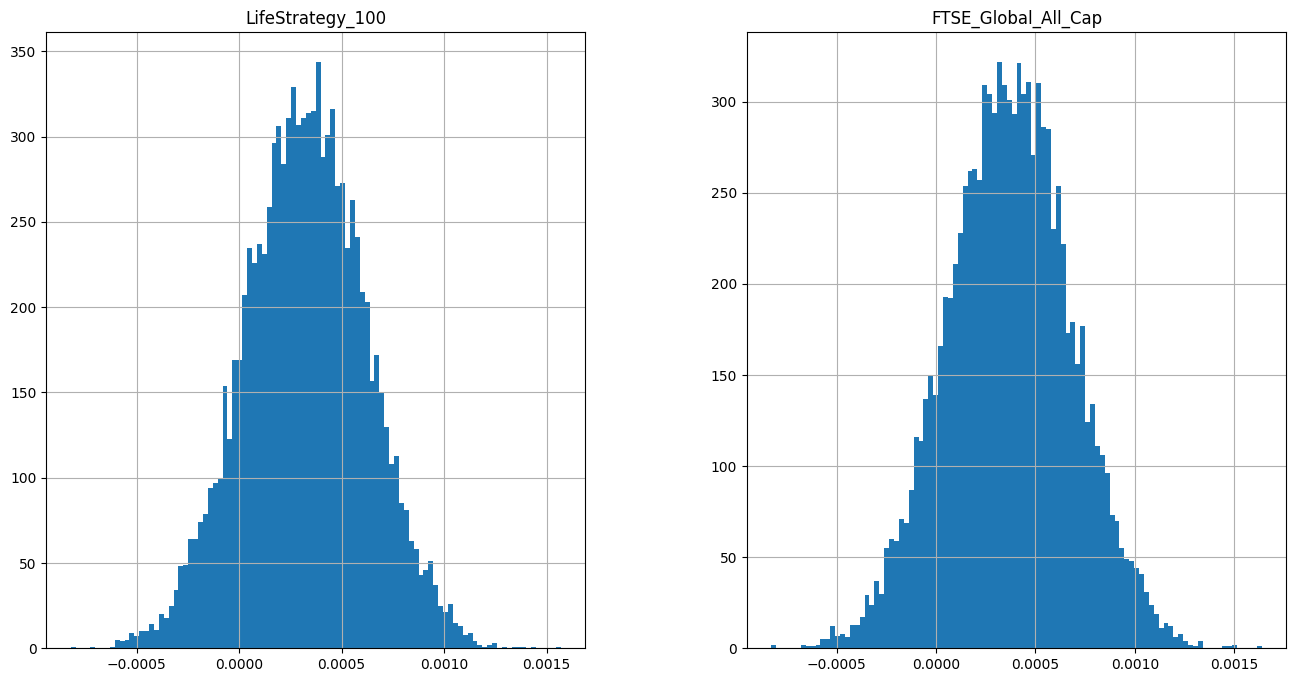

In [13]:
def get_random_sample(inp_df, n = 0):
    """
    Returns a random sample from the input dataframe with replacement.
    If n is 0 returns a sample the same length as the input dataframe.
    
    Args:
        inp_df: dataframe
            pandas dataframe to sample.
        n: int
            the number of rows to sample.
    Returns:
        dataframe
            random sample of inp_df.
    """     
    if n > 0:
        return inp_df.iloc[np.random.choice(len(inp_df), n, replace=True)].reset_index(drop=True)
    else:
        return inp_df.iloc[np.random.choice(len(inp_df), len(inp_df), replace=True)].reset_index(drop=True)

def get_bootstraps(inp_df, simulations):
    """
    Returns a dataframe of bootstrapped means.
    
    Args:
        inp_df: dataframe
            pandas dataframe to bootstrap.
        simulations: int
            the number of simulations to run.
    Returns:
        dataframe
            dataframe of resampled means.
    """       
    results_dict = {}

    for col in inp_df.columns:
        results_dict[col] = list()

    for i in tqdm(range(simulations), 'Getting bootstrap replicates'):
            boot_df = get_random_sample(inp_df)

            for col in inp_df.columns:
                results_dict[col].append(boot_df[col].mean())
    
    return pd.DataFrame(results_dict)
            
clt_df = get_bootstraps(vg_funds_LR, 10000)

clt_df.hist(bins=binner(clt_df))
plt.show()


The central limit theorem states that if you take a sufficiently large amount of random samples from the population with replacement, then the distribution of the sample means will be approximately normally distributed. This seems to be the case from the histograms, but if we look at the descriptive statistics, we'll be able to see if the difference between the two funds and then test if any difference is significant using a two sampled T-Test.

In [14]:
clt_describe_df = desc_stats(clt_df)
clt_describe_df

t_stat, p_value = stats.ttest_ind(clt_describe_df[clt_describe_df.columns[0]], clt_describe_df[clt_describe_df.columns[1]])

print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  1.1075043436619664e-07
P-Value:  0.9999999125493775


The difference between the funds couldn't be any less significant (technically it could but at 0.99 p-value it's close to identical), far above the 0.05 alpha level. As the results are so similar, I would be confident suggesting that the global exposure is worth taking the extra volatility for the better risk adjusted returns and therefore the VG FTSE Global All Cap would be the better choice of the two. Obviously this comparison means that there is an amount of selection bias in the decision making process, however the hypothesis of global exposure being a more attractive risk than a higher UK weighting means that the decision has a logical basis behind it.

Next we'll compare these funds to the other LifeStrategy funds, which have a varying allocation of bond exposure instead of 100% equity. This is traditionally considered to reduce risk due to the negative correlation between equities and bonds. We'll also include a US-centric fund in the form of the Vanguard U.S. Equity Index Fund to see if this outperforms global or UK centric weightings. 

The previous steps taken in this notebook will be condensed into a single function for this comparison with the code below:

In [15]:
def full_production(funds_list, inp_res):
    """
    Runs all previous steps in one call.
    
    Args:
        funds_list: dict
            dictionary of fund codes and names key values.
        inp_res: string
            the desired resolution.
    """       
    inp_funds = get_timeseries(funds_list, inp_res)

    inp_funds_norm = inp_funds.div(inp_funds.iloc[0])
    inp_funds_norm.plot()
    plt.title(f'Normalised {selected_resolution} price series')
    plt.show()

    inp_funds_LR = np.log(inp_funds).diff().dropna()
    inp_funds_LR.hist(bins=binner(inp_funds_LR), edgecolor='k')
    plt.show()

    inp_metric_comparison = desc_stats(inp_funds_LR)

    for col in inp_funds_LR.columns:    
        inp_metric_comparison.loc['Sharpe_Ratio', col] = round(sharpe_ratio(inp_funds_LR[col], 0, 1, resolutions[selected_resolution][1]),3)
        inp_metric_comparison.loc['Profit_Factor', col] = round(profit_factor(inp_funds_LR[col]),3)
        inp_metric_comparison.loc['Robust_Sharpe_Ratio', col] = round(robust_sharpe_ratio(inp_funds_LR[col], 0, 1, resolutions[selected_resolution][1]),3)

    display(inp_metric_comparison)
    
    inp_normality_results_df = pd.DataFrame()

    for col in inp_funds_LR.columns:
        AD, crit, sig = stats.anderson(inp_funds_LR[col], dist='norm')
        inp_normality_results_df.loc['KS Test', col] = kstat(inp_funds_LR, col)
        inp_normality_results_df.loc['JB Test', col] = jarque_bera(inp_funds_LR[col])[1]

    display(inp_normality_results_df)
        
    if (inp_normality_results_df.loc['JB Test'].mean() < 0.05) and (inp_normality_results_df.loc['KS Test'].mean() < 0.05):
        potential_dists = [
            'cauchy',
            'gennorm',
            'laplace',
            'norm',
            'uniform',
        ]

        inp_dist_df = pd.DataFrame()

        for col in tqdm(inp_funds_LR.columns):

            data = inp_funds_LR[col]

            for dist_str in (potential_dists):
                dist = getattr(stats, dist_str)
                parameters = dist.fit(data)
                rve = dist.rvs(*parameters, size=len(data))
                inp_dist_df.loc[dist_str, f'LLH_{col}'] = dist.logpdf(data,*parameters).sum()

        inp_dist_df['Mean_LLH'] = inp_dist_df.mean(axis=1)
        inp_dist_df.sort_values(by='Mean_LLH', ascending=False)


    inp_clt_df = get_bootstraps(inp_funds_LR, 10000)

    inp_clt_df.hist(bins=binner(inp_clt_df))
    plt.show()   

    clt_describe_df = desc_stats(inp_clt_df)
    display(clt_describe_df)

Comparison of US only equity funds and LifeStrategy funds which have varying proportion of bonds to the equity. For example, the LifeStrategy 80% has 80:20 proportion of equities to bonds.

[*********************100%***********************]  7 of 7 completed


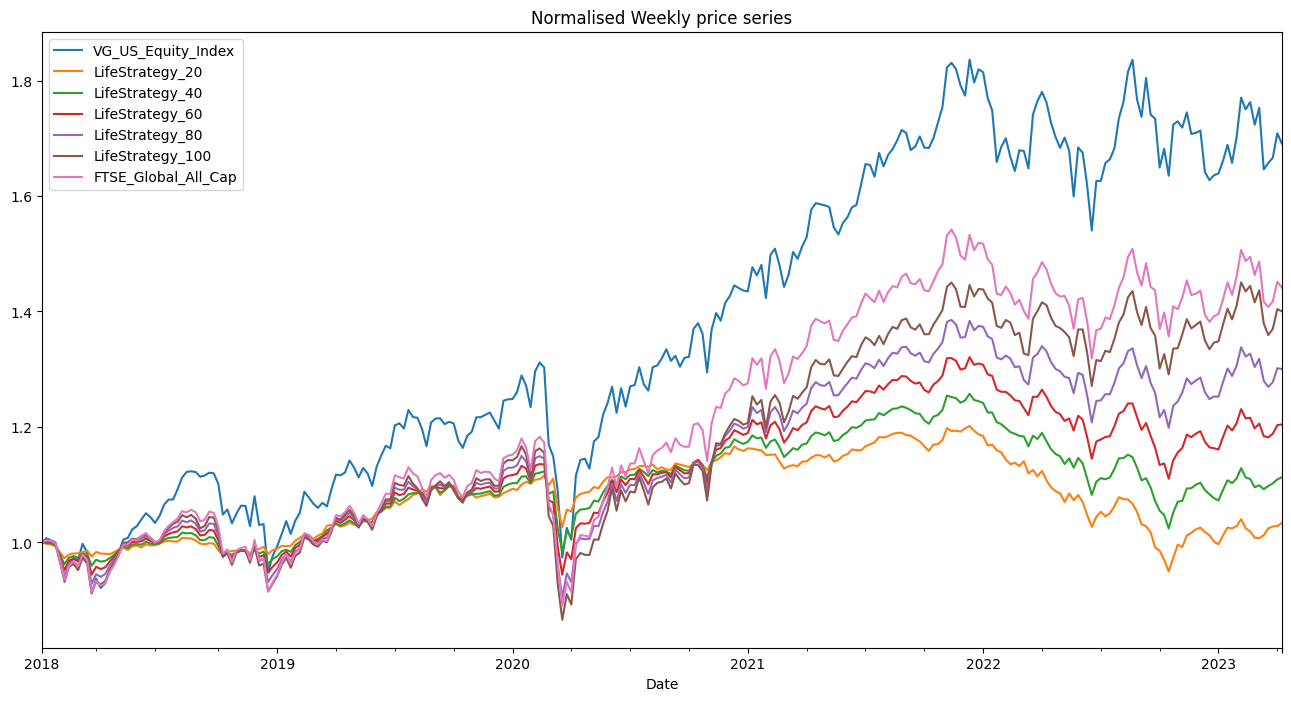

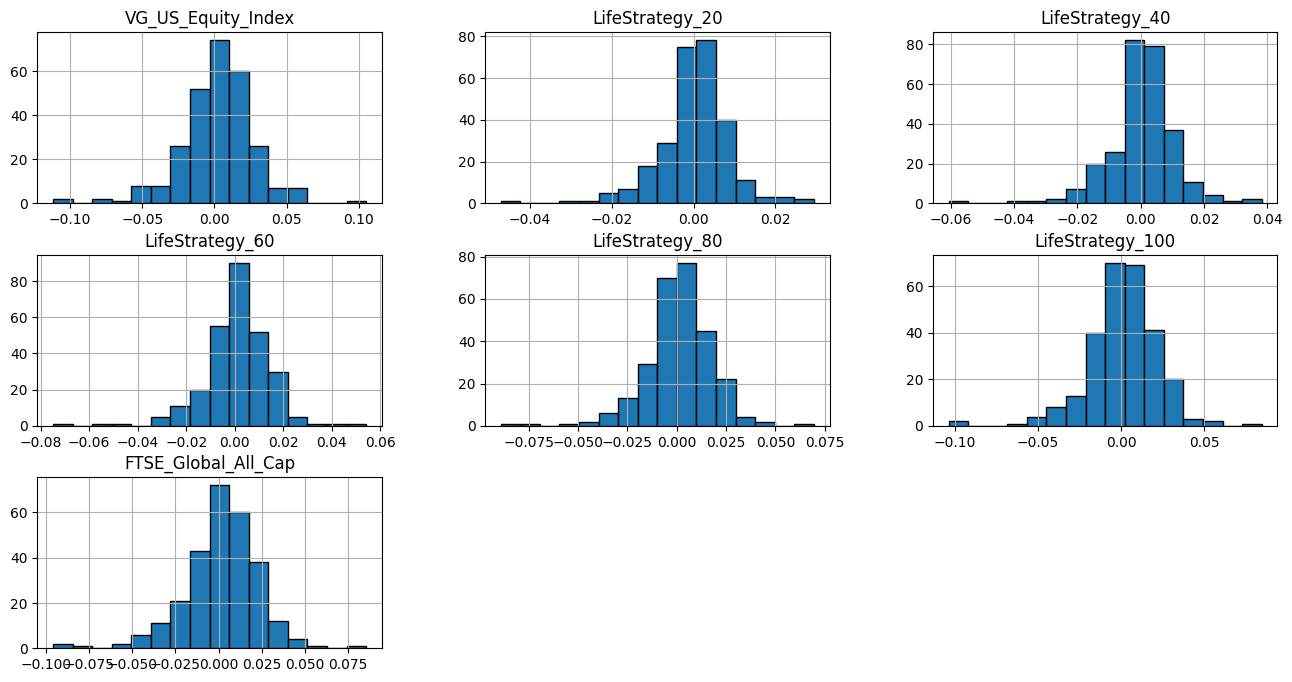

,VG_US_Equity_Index,LifeStrategy_20,LifeStrategy_40,LifeStrategy_60,LifeStrategy_80,LifeStrategy_100,FTSE_Global_All_Cap
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,0.001917,0.000121,0.000390,0.000678,0.000959,0.001229,0.001334
std,0.025289,0.008513,0.010509,0.013645,0.017286,0.021187,0.021607
min,-0.111692,-0.047107,-0.060707,-0.074914,-0.089231,-0.103633,-0.095898
25%,-0.011082,-0.003482,-0.003906,-0.004915,-0.007486,-0.009156,-0.008992
50%,0.003310,0.000798,0.000889,0.001199,0.001829,0.002017,0.002935
75%,0.016010,0.004773,0.006582,0.008083,0.010880,0.013608,0.014324
max,0.104952,0.029416,0.038189,0.054108,0.069515,0.084476,0.085392
Var,0.000640,0.000072,0.000110,0.000186,0.000299,0.000449,0.000467
Skewness,-0.678002,-0.814270,-0.914554,-0.893730,-0.863844,-0.843478,-0.703145


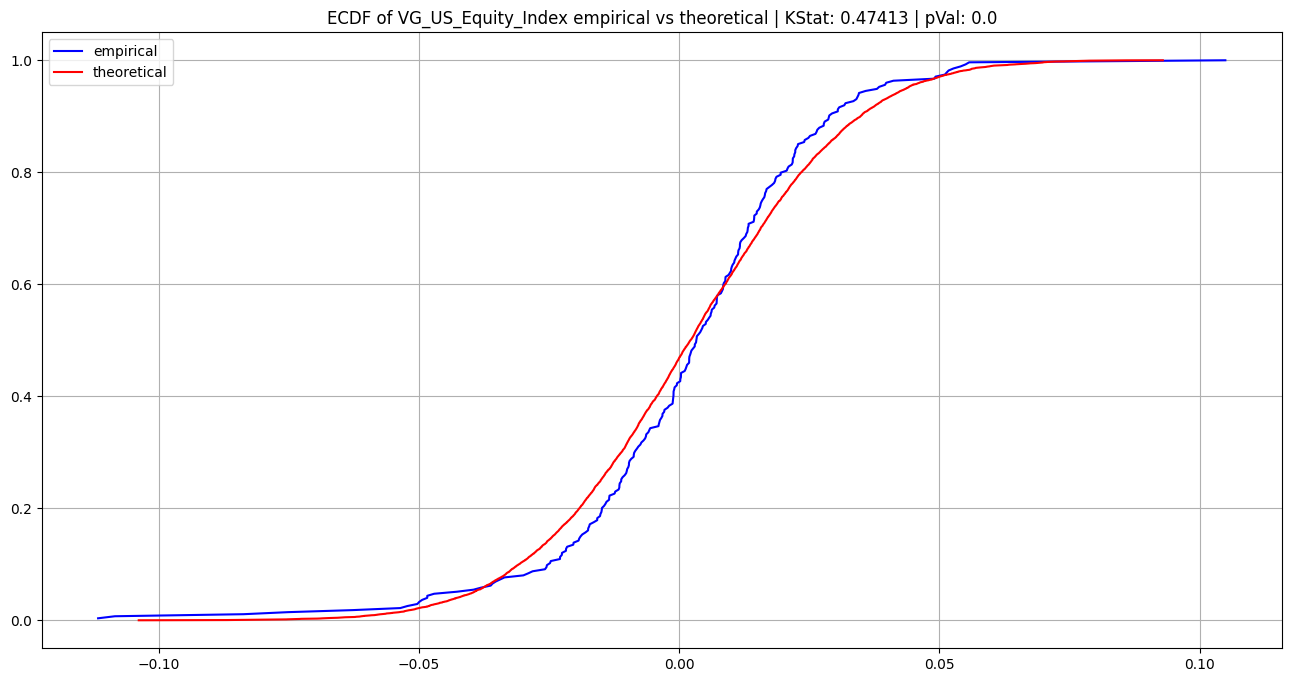

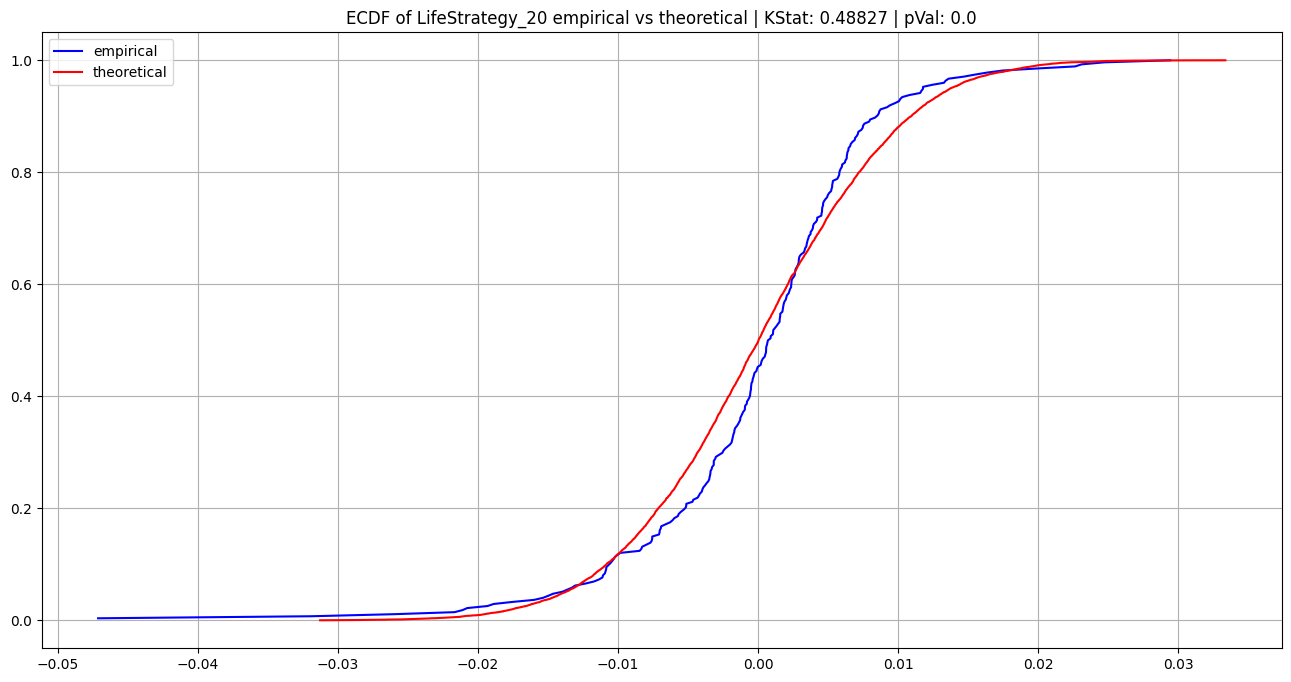

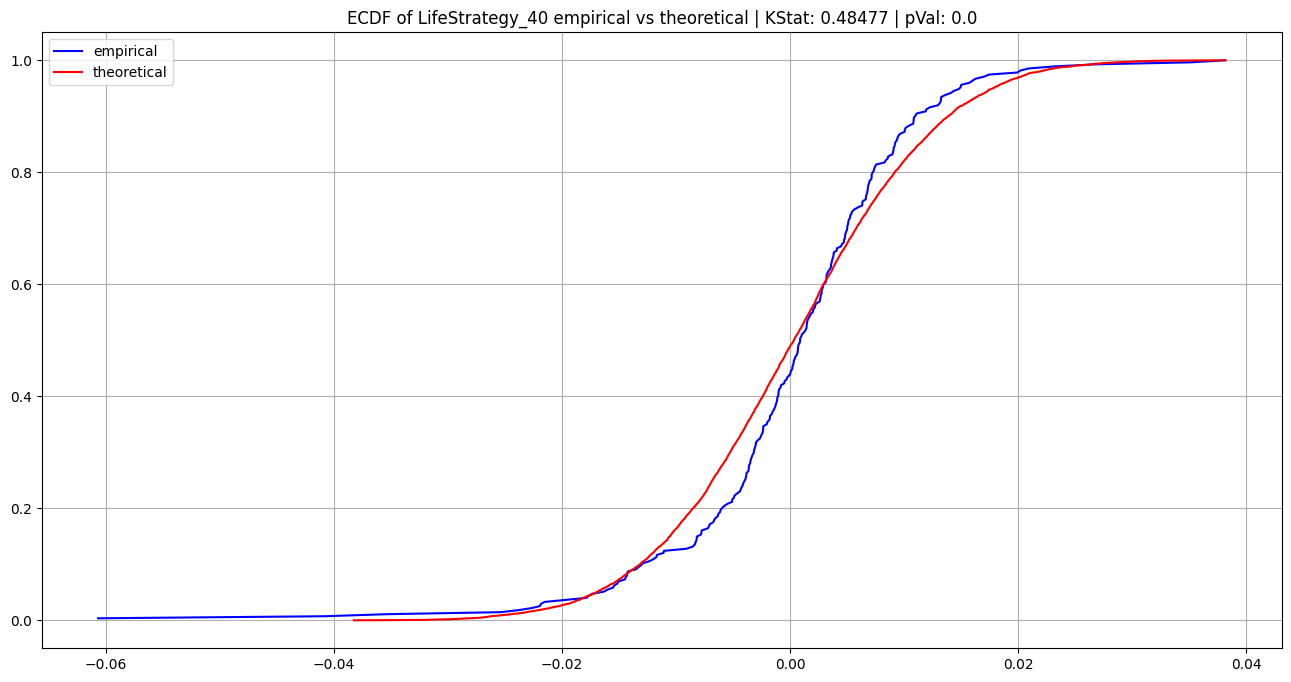

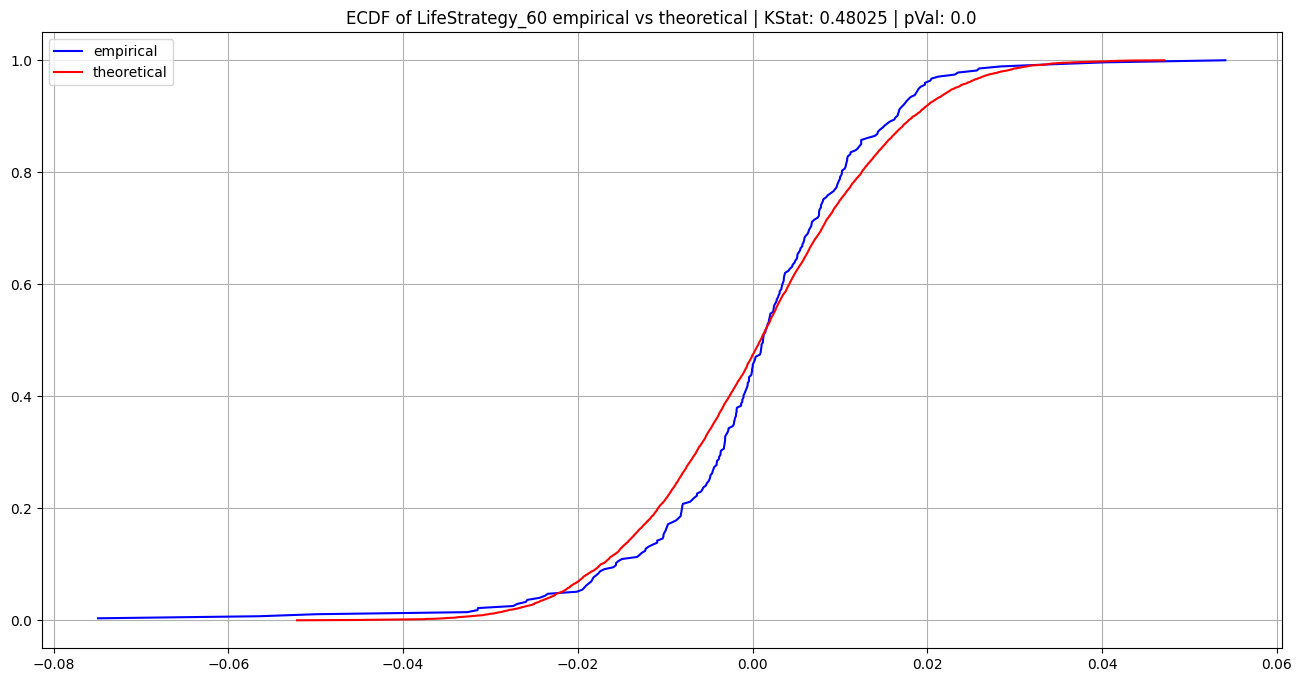

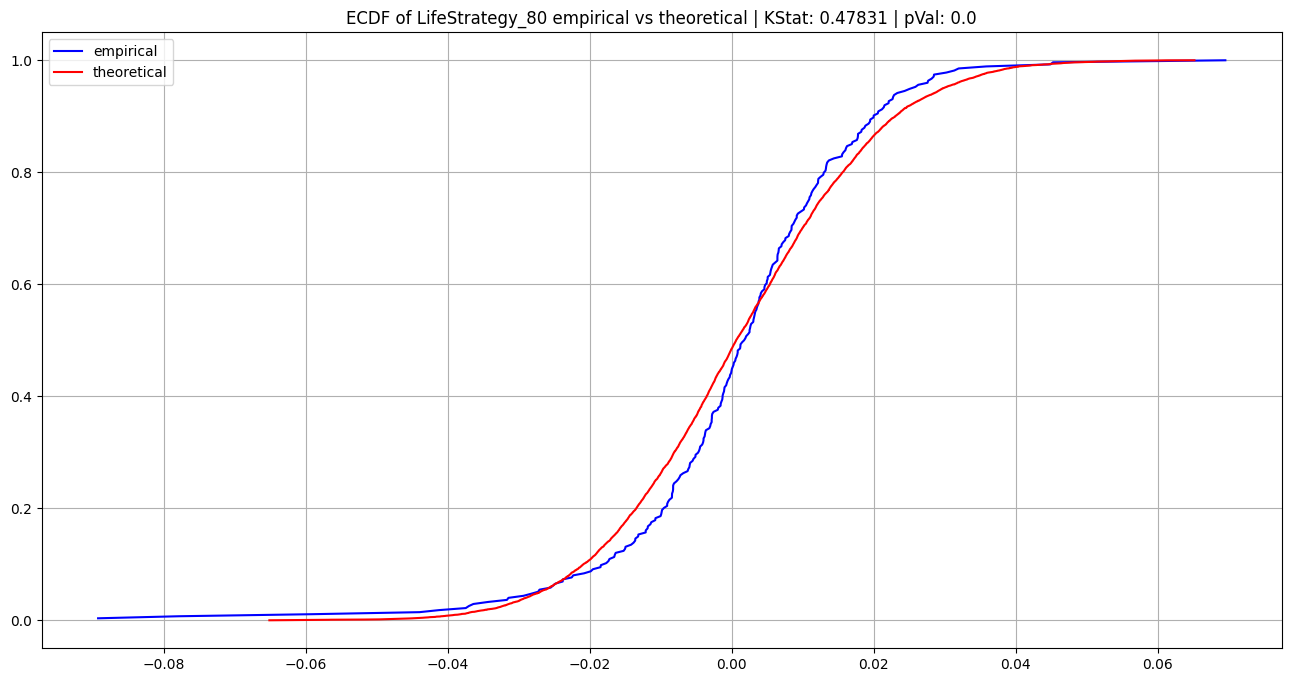

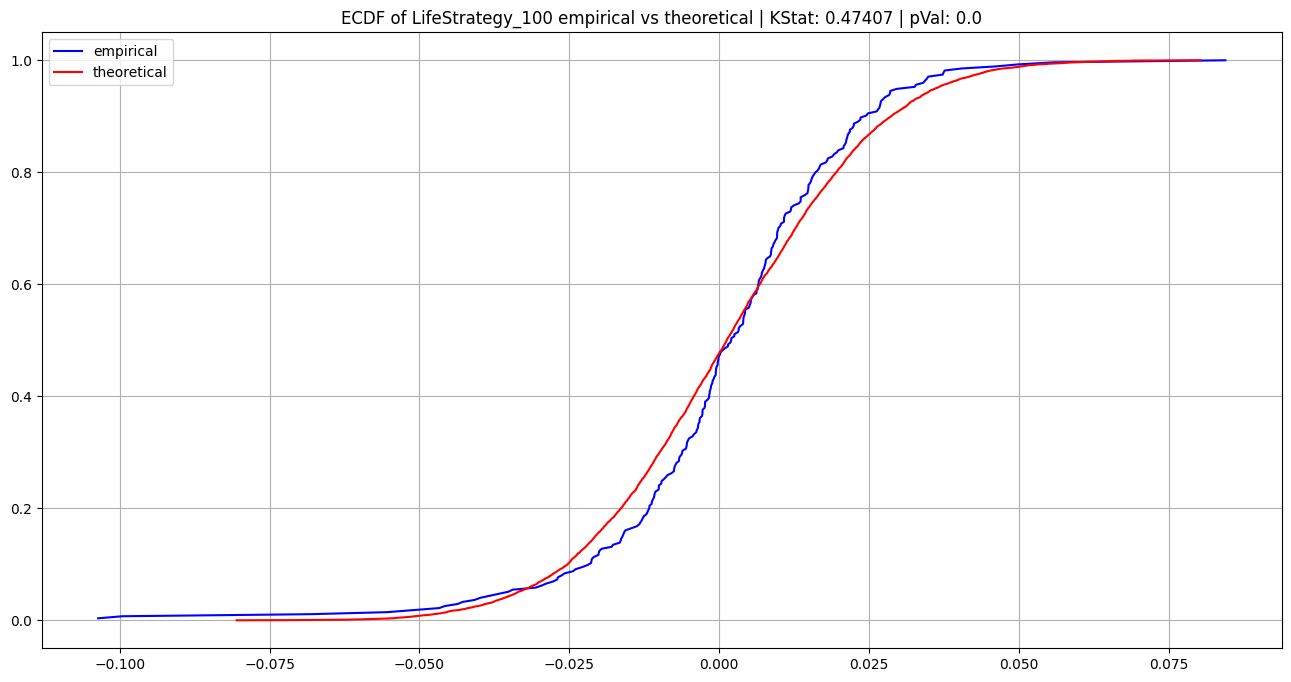

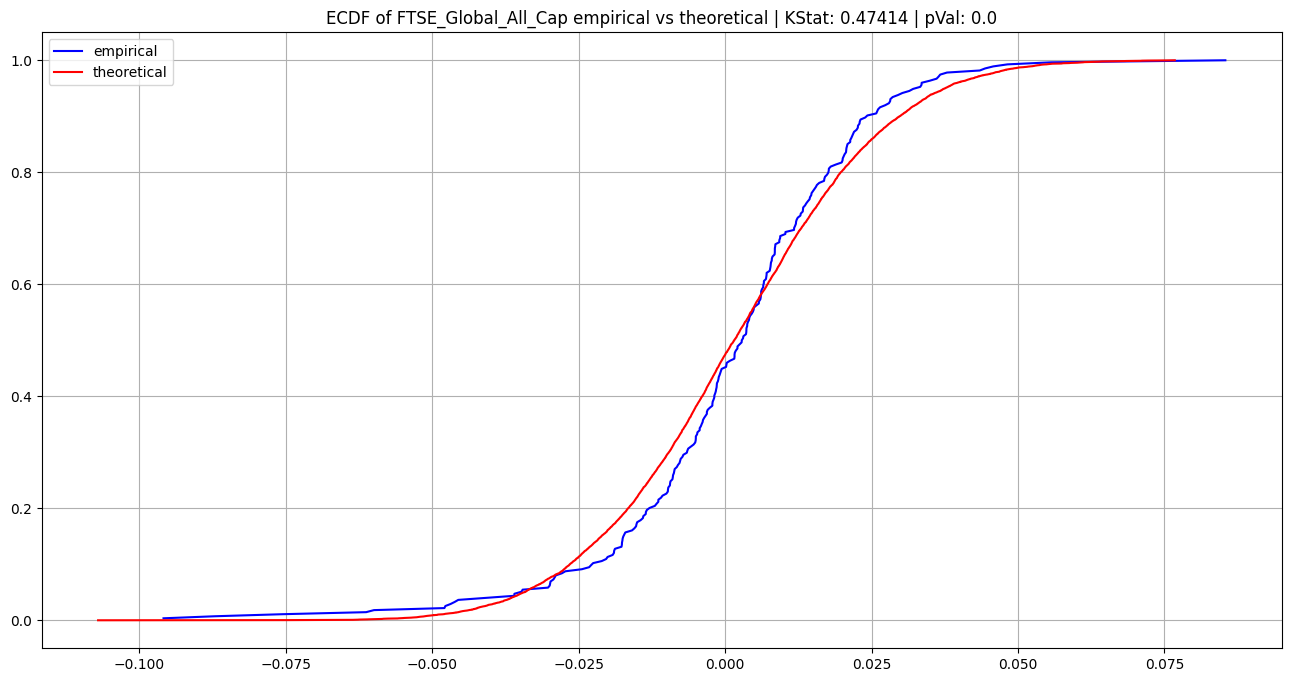

,VG_US_Equity_Index,LifeStrategy_20,LifeStrategy_40,LifeStrategy_60,LifeStrategy_80,LifeStrategy_100,FTSE_Global_All_Cap
KS Test,4.437803e-57,9.915818e-61,8.179532e-60,1.211786e-58,3.828818e-58,4.612953e-57,4.409767e-57
JB Test,7.856632e-34,7.893189e-55,3.819317e-78,5.366836e-71,5.619214e-61,1.697741e-53,1.240224e-29


Getting bootstrap replicates: 100%|█████| 10000/10000 [00:04<00:00, 2270.69it/s]


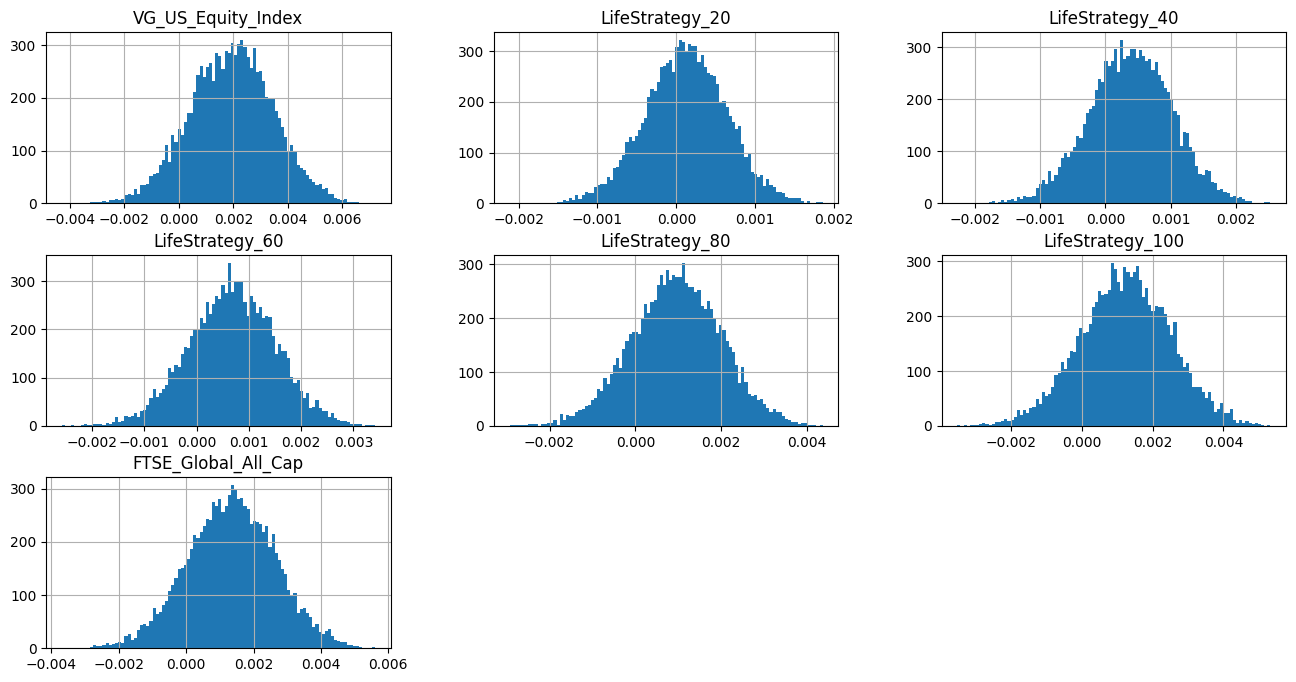

,VG_US_Equity_Index,LifeStrategy_20,LifeStrategy_40,LifeStrategy_60,LifeStrategy_80,LifeStrategy_100,FTSE_Global_All_Cap
count,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,0.001924,1.185490e-04,3.869324e-04,6.750472e-04,0.000955,0.001225,0.001333
std,0.001524,5.167141e-04,6.379255e-04,8.267037e-04,0.001045,0.001280,0.001304
min,-0.004300,-2.114348e-03,-2.265767e-03,-2.584518e-03,-0.002931,-0.003520,-0.003694
25%,0.000877,-2.220860e-04,-3.673715e-05,1.219020e-04,0.000260,0.000381,0.000464
50%,0.001953,1.224829e-04,3.941279e-04,6.834785e-04,0.000970,0.001242,0.001354
75%,0.002960,4.696522e-04,8.240556e-04,1.245422e-03,0.001674,0.002113,0.002234
max,0.007199,1.853240e-03,2.526664e-03,3.412778e-03,0.004360,0.005330,0.005603
Var,0.000002,2.669934e-07,4.069489e-07,6.834389e-07,0.000001,0.000002,0.000002
Skewness,-0.064957,-5.548556e-02,-7.766510e-02,-8.210168e-02,-0.081034,-0.079011,-0.073684


In [16]:
funds_plus_bonds = {
    '0P0000TKZO.L' : 'LifeStrategy_100', 
    '0P00018XAR.L' : 'FTSE_Global_All_Cap',
    '0P0000TKZM.L' : 'LifeStrategy_80',
    '0P0000TKZK.L' : 'LifeStrategy_60',
    '0P0000TKZI.L' : 'LifeStrategy_40',
    '0P0000TKZG.L' : 'LifeStrategy_20',
    '0P0000KSPA.L' : 'VG_US_Equity_Index',
}

selected_resolution = 'Weekly'

full_production(funds_plus_bonds, resolutions[selected_resolution][0])

As we can see from the descriptive statistics, the US-centric weighted fund outperforms the FTSE Global All Cap by a large amount. It is my belief that whilst the returns are much better, the performance of US equities may not be repeated in the future, and therefore the diversification with global and emerging market exposure is a worthy sacrifice for lesser returns.

Rather surprisingly, the bond allocations in the LifeStrategy funds do not do much to improve the sharpe ratio, robust sharpe ratio or profit factor of the funds. This is surprising as it appears to be at odds with the general consensus that bond exposure can reduce volatility at a greater rate than it's reduction in returns, leading to a greater sharpe ratio. This could be due to a potential shift in the relationship between equities and bonds seen in the last few years as the data used in this study is from 2018 to present. Further study on older data is needed to confirm this at a later date.